In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import gc
import os
import pickle
import warnings

warnings.filterwarnings('ignore')
np.random.seed(0)

In [4]:
import tensorflow as tf
from tensorflow.keras.losses import Huber
import keras
from keras import layers, models, optimizers
from keras.regularizers import L1L2
from keras.layers import InputSpec
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import keras.backend as K


Using TensorFlow backend.


In [5]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE

from scipy.optimize import linear_sum_assignment

In [6]:
def exp(a):
    if a < 0:
        return np.log(-a)
    else:
        return np.log(a)
    
tr = pd.read_csv('./data/train.csv')
te = pd.read_csv('./data/test.csv')

sub = pd.read_csv('./data/sample_submission.csv', index_col=0)

column_number = {}
for i, column in enumerate(sub.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

tr['type_num'] = tr['type'].apply(lambda x: to_number(x, column_number))

target = tr['type_num']
t = target.copy()

train_X = tr.drop(['id', 'type', 'type_num'], axis=1)
test_X = te.drop(['id',], axis=1)

ctd = []
for c in train_X.columns[1:]:
    mini = np.min(test_X[c])
    maxi = np.max(test_X[c])
    ctd += (list(train_X[c][train_X[c].map(lambda x: x if mini < x < maxi else 'c') == 'c'].index.values))
    
ctd = np.array(list(set(ctd)))
train_X = train_X.drop(ctd)
train_X = train_X.reset_index().drop('index', axis=1)


train_X['t'] = np.ones(len(train_X))
test_X['t'] = np.zeros(len(test_X))
m = pd.concat([train_X, test_X])

for c in m.columns[1:-1]:
    m[c] = m[c].map(exp)
    m[c] = (m[c] - np.min(m[c]))/(np.max(m[c]) - np.min(m[c]))
#     m[c] = (m[c] - np.mean(m[c]))/np.std(m[c])
    
    
train_X = m[m['t'] == 1].drop(['t'], axis=1)
test_X = m[m['t'] == 0].drop(['t'], axis=1)

fiber = pd.get_dummies(m['fiberID'], prefix='fiber')
tr_fiber = fiber.iloc[0:len(train_X), :]
te_fiber = fiber.iloc[len(train_X): , :]

train_X = train_X.drop('fiberID', axis=1)
test_X = test_X.drop('fiberID', axis=1)

t = t.drop(ctd)
t = t.reset_index().drop('index', axis=1)

target = t.copy()
target = target.values.flatten()
target_wide = to_categorical(target)

te_X = test_X.copy()
tr_X = train_X.copy()

In [ ]:
res_hist = []
for i in range(10, 30):
    km = KMeans(random_state=42, n_clusters=19).fit_predict(tr_X.values)
    print(i)
    res_hist.append(  
        [       metrics.normalized_mutual_info_score(target.values, km),
                metrics.adjusted_mutual_info_score(target.values, km),
                metrics.normalized_mutual_info_score(target.values, km),
                #acc(target.values, ypred)
        ]
     )
    
# aux_wide = to_categorical(aux)

In [18]:
def acc(ypred, y):
#     assert len(y) > 0
#     assert len(np.unique(ypred)) == len(np.unique(y))
    
    s = np.unique(ypred)
    t = np.unique(y)
    
    N = len(np.unique(y))
    C = np.zeros((N, N), dtype = np.int32)
    for i in range(N):
        for j in range(N):
            idx = np.logical_and(ypred == s[i], y == t[j])
            C[i][j] = np.count_nonzero(idx)
    
    # convert the C matrix to the 'true' cost
    Cmax = np.amax(C)
    C = Cmax - C
    # 
    indices = np.array(list(map(lambda x: list(x), list(zip(*linear_sum_assignment(C))))))
    row = indices[:][:, 0]
    col = indices[:][:, 1]
    # calculating the accuracy according to the optimal assignment
    count = 0
    for i in range(N):
        idx = np.logical_and(ypred == s[row[i]], y == t[col[i]] )
        count += np.count_nonzero(idx)
    
    return 1.0*count/len(y)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]

    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [30]:
def mutual_info_loss(c, c_given):
    eps = 1e-8
    conditional_entropy = K.mean(-K.sum(K.log(c_given + eps)*c, axis=1))
    entropy = K.mean(-K.sum(K.log(c+eps)*c, axis=1))

    return conditional_entropy + entropy

In [13]:
n_clusters = 19
def AE():
    inputs = layers.Input(shape = (tr_X.shape[1],) )
    
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(inputs)
    x = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    encoder_out = layers.Dense(n_clusters, activation = 'linear', kernel_initializer='he_normal')(x)
    
    x = layers.Dense(32, activation = 'relu', kernel_initializer='he_normal')(encoder_out)
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    decoder_out = layers.Dense(tr_X.shape[1], kernel_initializer='he_normal', activation='linear')(x)
    
    encoder = models.Model(inputs, encoder_out, name='encoder')
    
    ae = models.Model(inputs, decoder_out, name='AE')
    
    return ae, encoder


class ClusteringLayer(layers.Layer):

    def __init__(self, n_clusters=n_clusters, weights=None, alpha=1.0,**kwargs):
        
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
#         self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        
        self.built = True
        
        super(ClusteringLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters
    

In [64]:
class DEC(object):
    def __init__(self,
                 n_clusters=19,
                 alpha=1.0,
                 init='he_normal'):

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = AE()

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = models.Model(inputs=self.encoder.input, outputs=clustering_layer)
        self.compile()

    def pretrain(self, x, y=None, optimizer='adam', epochs=500, batch_size=1024):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        # begin pretraining
        es = EarlyStopping(patience=20, restore_best_weights=True, monitor='loss')
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks = [es])
        print('Pretraining time: %ds' % round(time() - t0))
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=5e4, batch_size=1024*16, tol=1e-3,
            update_interval=200, epohcs=100):
        
#         if not self.pretrained:
#             self.pretraine(x)

        print('Update interval', update_interval)
        save_interval = int(x.shape[0] / batch_size) * epohcs  
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.accuracy_score(y, y_pred), 5)
                    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
                    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    break

            # train on batch
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print(str(ite))

        return y_pred


In [43]:
def make_SimpleAE():
    K.clear_session()
    inputs = layers.Input(shape=(tr_X.shape[1], ))

    x = layers.Dense(64)(inputs)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    x = layers.Dense(32)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    cl = layers.Dense(19)(x)

    x = layers.Dense(32)(cl)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    outputs = layers.Dense(tr_X.shape[1])(x)

    m = models.Model(inputs, outputs)
    cl = models.Model(inputs, cl)
    return m, cl

In [12]:
def make_AE():
#     K.clear_session()
    inputs1 = layers.Input(shape=(tr_X.shape[1], ))
    inputs2 = layers.Input(shape=(target_wide.shape[1], ))
#     x1 = layers.Dense(64)(inputs1)
    x2 = layers.Dense(64)(inputs2)
    
    x = layers.Concatenate()([inputs1, x2])
    
    x = layers.Dense(32)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    cl = layers.Dense(19)(x)

    x = layers.Dense(32)(cl)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    outputs1 = layers.Dense(tr_X.shape[1])(x)
    outputs2 = layers.Dense(target_wide.shape[1], activation='softmax')(x)

    m = models.Model([inputs1, inputs2], [outputs1, outputs2])
    cl = models.Model([inputs1, inputs2], cl)
    return m, cl

In [54]:
def make_VAE():
#     K.clear_session()
    inputs1_shape = tr_X.shape
    inputs2_shape = target_wide.shape
    
    inputs1 = layers.Input(shape=(inputs1_shape[1], ))
    inputs2 = layers.Input(shape=(inputs2_shape[1], ))
#     x1 = layers.Dense(64)(inputs1)
    x2 = layers.Dense(64)(inputs2)
    
    x = layers.Concatenate()([inputs1, x2])
    
    x = layers.Dense(32)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    z_mean = layers.Dense(19)(x)
    z_log_var = layers.Dense(19)(x)
    
    cl = layers.Lambda(sampling, output_shape=(19, ))([z_mean, z_log_var])

    x = layers.Dense(32)(cl)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    outputs1 = layers.Dense(inputs1_shape[1])(x)
    outputs2 = layers.Dense(inputs2_shape[1], activation='softmax')(x)

    m = models.Model([inputs1, inputs2], [outputs1, outputs2])
    cl = models.Model([inputs1, inputs2], cl)
    return m, cl

In [106]:
m, cl = make_AE()

In [55]:
m, cl = make_VAE()

In [66]:
d = DEC()

In [44]:
m, cl = make_SimpleAE()

In [67]:
d.pretrain(tr_X.values)
d.fit(tr_X.values)

...Pretraining...
Epoch 1/500
199514/199514 [==============================] - 1s 5us/step - loss: 0.0055
Epoch 2/500
199514/199514 [==============================] - 1s 4us/step - loss: 6.0060e-05
Epoch 3/500
199514/199514 [==============================] - 1s 4us/step - loss: 4.9469e-05
Epoch 4/500
199514/199514 [==============================] - 1s 4us/step - loss: 3.8767e-05
Epoch 5/500
199514/199514 [==============================] - 1s 4us/step - loss: 3.0492e-05
Epoch 6/500
199514/199514 [==============================] - 1s 4us/step - loss: 2.3914e-05
Epoch 7/500
199514/199514 [==============================] - 1s 4us/step - loss: 1.8463e-05
Epoch 8/500
199514/199514 [==============================] - 1s 4us/step - loss: 1.4946e-05
Epoch 9/500
199514/199514 [==============================] - 1s 4us/step - loss: 1.2600e-05
Epoch 10/500
199514/199514 [==============================] - 1s 4us/step - loss: 1.0796e-05
Epoch 11/500
199514/199514 [==============================] - 1s 

199514/199514 [==============================] - 1s 5us/step - loss: 2.2164e-06
Epoch 90/500
199514/199514 [==============================] - 1s 5us/step - loss: 1.9958e-06
Epoch 91/500
199514/199514 [==============================] - 1s 5us/step - loss: 2.2633e-06
Epoch 92/500
199514/199514 [==============================] - 1s 5us/step - loss: 1.9929e-06
Epoch 93/500
199514/199514 [==============================] - 1s 5us/step - loss: 2.1005e-06
Epoch 94/500
199514/199514 [==============================] - 1s 5us/step - loss: 2.0313e-06
Epoch 95/500
199514/199514 [==============================] - 1s 4us/step - loss: 2.1048e-06
Epoch 96/500
199514/199514 [==============================] - 1s 5us/step - loss: 2.0527e-06
Epoch 97/500
199514/199514 [==============================] - 1s 5us/step - loss: 1.9723e-06
Epoch 98/500
199514/199514 [==============================] - 1s 5us/step - loss: 2.0220e-06
Epoch 99/500
199514/199514 [==============================] - 1s 5us/step - loss: 2

array([ 9,  4, 17, ...,  8, 12,  1], dtype=int64)

In [108]:
m.compile(loss=['mse', 'categorical_crossentropy'], optimizer=optimizers.Adam(2e-4,0.5))

In [45]:
m.compile(loss='mse', optimizer=optimizers.Adam(2e-4,0.5))

In [109]:
history = m.fit([tr_X.values, target_wide], [tr_X.values, target_wide],
     epochs=100,
     batch_size=1024*128
     )

Epoch 1/100
199514/199514 [==============================] - 1s 5us/step - loss: 2.9715 - dense_6_loss: 0.1065 - dense_7_loss: 2.8636
Epoch 2/100
199514/199514 [==============================] - 0s 2us/step - loss: 2.9526 - dense_6_loss: 0.1047 - dense_7_loss: 2.8464
Epoch 3/100
199514/199514 [==============================] - 0s 2us/step - loss: 2.9336 - dense_6_loss: 0.1032 - dense_7_loss: 2.8288
Epoch 4/100
199514/199514 [==============================] - 0s 2us/step - loss: 2.9150 - dense_6_loss: 0.1020 - dense_7_loss: 2.8115
Epoch 5/100
199514/199514 [==============================] - 0s 2us/step - loss: 2.8964 - dense_6_loss: 0.1008 - dense_7_loss: 2.7943
Epoch 6/100
199514/199514 [==============================] - 0s 2us/step - loss: 2.8776 - dense_6_loss: 0.0997 - dense_7_loss: 2.7765
Epoch 7/100
199514/199514 [==============================] - 0s 2us/step - loss: 2.8587 - dense_6_loss: 0.0987 - dense_7_loss: 2.7585
Epoch 8/100
199514/199514 [==============================] - 0

In [48]:
history = m.fit(tr_X.values, tr_X.values,
     epochs=100,
     batch_size=1024*128
     )

Epoch 1/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0488e-05
Epoch 2/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0484e-05
Epoch 3/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0480e-05
Epoch 4/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0475e-05
Epoch 5/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0471e-05
Epoch 6/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0467e-05
Epoch 7/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0463e-05
Epoch 8/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0458e-05
Epoch 9/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0454e-05
Epoch 10/100
199514/199514 [==============================] - 0s 1us/step - loss: 4.0450e-05
Epoch 11/100
199514/199514 [==============================] - 0s 1us/step - los

In [33]:
# baseline clustering
ypred = KMeans(random_state=42, n_clusters=19).fit_predict(tr_X.values)
print(  metrics.normalized_mutual_info_score(target, ypred),
        metrics.adjusted_mutual_info_score(target, ypred),
        metrics.adjusted_rand_score(target, ypred),
        acc(target, ypred)
     )

0.5428361693560936 0.5426900869319222 0.2949167755541345 0.4121114307767876


In [49]:
# simpleAE croessentropy
ypred = KMeans(random_state=42, n_clusters=19).fit_predict(cl.predict(tr_X.values))
print(  metrics.normalized_mutual_info_score(target, ypred),
        metrics.adjusted_mutual_info_score(target, ypred),
        metrics.adjusted_rand_score(target, ypred),
        acc(target, ypred)
     )

0.46693161370408354 0.466761816856011 0.24764363801052544 0.3398358009964213


In [110]:
# crossentropy_AE
ypred = KMeans(random_state=42, n_clusters=19).fit_predict(cl.predict([tr_X.values, target_wide]))
print(  metrics.normalized_mutual_info_score(target, ypred),
        metrics.adjusted_mutual_info_score(target, ypred),
        metrics.adjusted_rand_score(target, ypred),
        acc(target, ypred)
     )

0.9693615981603665 0.9693512013256339 0.8850382472043999 0.9324709042974428


In [63]:
# crossentropy_VAE
ypred = KMeans(random_state=42, n_clusters=19).fit_predict(cl.predict([tr_X.values, target_wide]))
print(  metrics.normalized_mutual_info_score(target, ypred),
        metrics.adjusted_mutual_info_score(target, ypred),
        metrics.adjusted_rand_score(target, ypred),
        acc(target, ypred)
     )

0.9040570553344737 0.9040260648664715 0.6479001890519294 0.6855709373778281


In [78]:
# DEC
ypred = d.predict(tr_X.values)
print(  metrics.normalized_mutual_info_score(target, ypred),
        metrics.adjusted_mutual_info_score(target, ypred),
        metrics.adjusted_rand_score(target, ypred),
        acc(target, ypred)
     )

0.5244476295202614 0.5242897376447933 0.3300675890703742 0.5157633048307387


In [ ]:
#mutual_AE
ypred = KMeans(random_state=42, n_clusters=19).fit_predict(cl.predict([tr_X.values, target_wide]))
print(  metrics.normalized_mutual_info_score(target.values, ypred),
        metrics.adjusted_mutual_info_score(target.values, ypred),
        metrics.adjusted_rand_score(target.values, ypred),
        acc(target.values, ypred)
     )

In [ ]:
#mutual_VAE
ypred = KMeans(random_state=42, n_clusters=19).fit_predict(cl.predict([tr_X.values, target_wide]))
print(  metrics.normalized_mutual_info_score(target.values, ypred),
        metrics.adjusted_mutual_info_score(target.values, ypred),
        metrics.adjusted_rand_score(target.values, ypred),
        acc(target.values, ypred)
     )

In [ ]:
#mutual_AE
ypred = KMeans(random_state=42, n_clusters=19).fit_predict(d.predict(tr_X.values).reshape(-1, 1))
print(  metrics.normalized_mutual_info_score(target.values, ypred),
        metrics.adjusted_mutual_info_score(target.values, ypred),
        metrics.adjusted_rand_score(target.values, ypred),
        acc(target.values, ypred)
     )

ValueError: 'c' argument has 199514 elements, which is not acceptable for use with 'x' with size 199514, 'y' with size 199514.

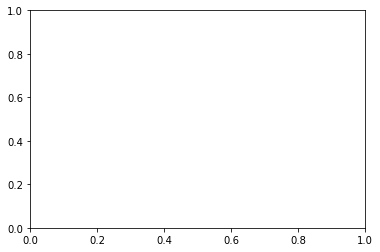

In [83]:
# KMeans
ypred = tr_X.values.copy()
tsne = TSNE(random_state=42, perplexity=100).fit_transform(ypred)
labels = KMeans(random_state=42, n_clusters=19).fit_predict(ypred)
xs = tsne[:,0]
ys = tsne[:,1]
plt.scatter(xs,ys,c=labels)
sns.scatterplot(xs,ys,labels)

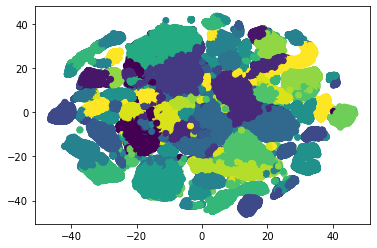

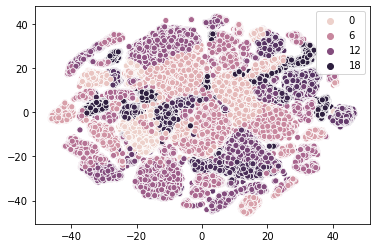

In [102]:
plt.scatter(xs,ys,c=labels)
plt.show()
sns.scatterplot(xs,ys, labels)

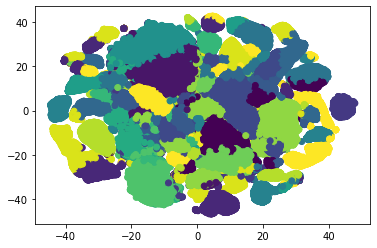

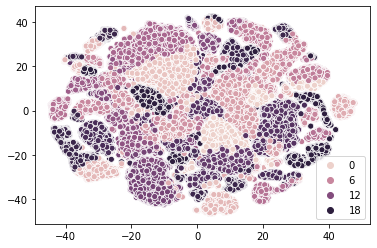

In [104]:
# DEC
ypred = d.encoder.predict(tr_X.values)
tsne = TSNE(random_state=42, perplexity=100).fit_transform(ypred)
labels = KMeans(random_state=42, n_clusters=19).fit_predict(ypred)
xs = tsne[:,0]
ys = tsne[:,1]
plt.scatter(xs,ys,c=labels)
plt.show()
sns.scatterplot(xs,ys,labels)

In [ ]:
# AE
ypred = cl.predict(tr_X.values)
tsne = TSNE(random_state=42, perplexity=100).fit_transform(ypred)
labels = KMeans(random_state=42, n_clusters=19).fit_predict(ypred)
xs = tsne[:,0]
ys = tsne[:,1]
plt.scatter(xs,ys,c=labels)
plt.show()
sns.scatterplot(xs,ys,labels)

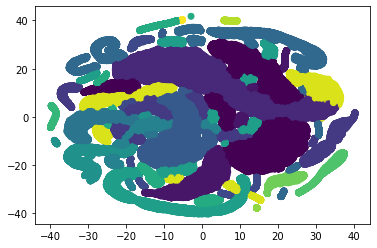

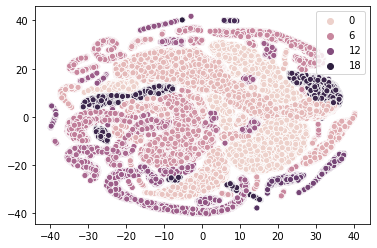

In [111]:
# AE
ypred = cl.predict([tr_X.values, target_wide])
tsne = TSNE(random_state=42, perplexity=100).fit_transform(ypred)
labels = KMeans(random_state=42, n_clusters=19).fit_predict(ypred)
xs = tsne[:,0]
ys = tsne[:,1]
plt.scatter(xs,ys,c=labels)
plt.show()
sns.scatterplot(xs,ys,labels)

In [ ]:
#######################

In [25]:
m, cl = make_AE()
m.compile(loss=['mse', 'categorical_crossentropy'], optimizer=optimizers.Adam(2e-4,0.5))

es = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

class CustomCallback(keras.callbacks.Callback):
    def __init__(self):
        self.nmi = []
        self.ami = []
        self.ari = []
        self.acc = []
        self.count = 0
        
    def on_epoch_end(self, batch, logs={}):
        self.count += 1
        if self.count % 100 == 0:
            
            ypred = KMeans(random_state=42, n_clusters=19).fit_predict(cl.predict([tr_X.values, target_wide]))
            self.nmi.append(metrics.normalized_mutual_info_score(target.values.flatten(), ypred))
            self.ami.append(metrics.adjusted_mutual_info_score(target.values.flatten(), ypred))
            self.ari.append(metrics.adjusted_rand_score(target.values.flatten(), ypred))
            self.acc.append(acc(target.values.flatten(), ypred))

            plt.plot(self.nmi)
            plt.plot(self.ari)
            plt.plot(self.acc)
            plt.show()

cc = CustomCallback()
        

Epoch 1/5
199514/199514 [==============================] - 0s 2us/step - loss: 3.0557 - dense_6_loss: 0.0852 - dense_7_loss: 2.9694


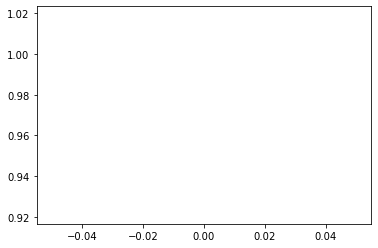

Epoch 2/5
199514/199514 [==============================] - 0s 1us/step - loss: 3.0419 - dense_6_loss: 0.0833 - dense_7_loss: 2.9576


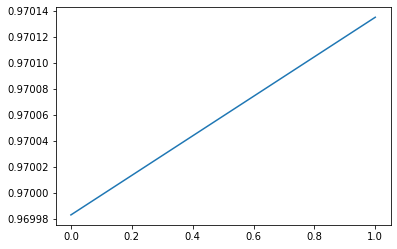

Epoch 3/5
199514/199514 [==============================] - 0s 1us/step - loss: 3.0297 - dense_6_loss: 0.0815 - dense_7_loss: 2.9472


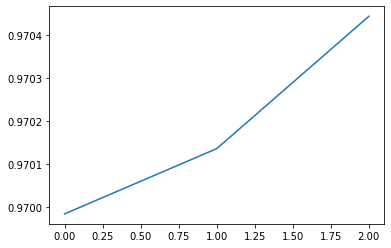

Epoch 4/5
199514/199514 [==============================] - 0s 1us/step - loss: 3.0179 - dense_6_loss: 0.0800 - dense_7_loss: 2.9371


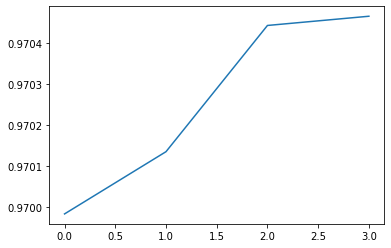

Epoch 5/5
199514/199514 [==============================] - 0s 1us/step - loss: 3.0066 - dense_6_loss: 0.0786 - dense_7_loss: 2.9272


KeyboardInterrupt: 

In [26]:
history = m.fit([train_X.values, target_wide], [tr_X.values, target_wide],
     epochs=5,
     batch_size=1024*128,
    callbacks=[es, cc]
     )

In [24]:
target.values.flatten()

array([ 8,  8,  8, ..., 10,  6,  8], dtype=int64)

In [69]:
np.unique(d.predict(tr_X.values))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=int64)

In [24]:
def make_AE_Dual():
    inputs1 = layers.Input(shape = (tr_X.values.shape[1], ))
    inputs2 = layers.Input(shape = (target_wide.shape[1], ))

    x = layers.Dense(64)(inputs1)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)
    x = layers.Dense(32)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)
    cl = layers.Dense(19)(x)

    x2 = layers.Dense(16)(inputs2)

    x = layers.Concatenate()([cl, x2])

    x = layers.Dense(32)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)
    x = layers.Dense(64)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    outputs1 = layers.Dense(tr_X.values.shape[1])(x)
    outputs2 = layers.Dense(target_wide.shape[1], activation='softmax')(x)

    cl = models.Model(inputs1, cl)
    m = models.Model([inputs1, inputs2], [outputs1, outputs2])
    
    return m, cl


In [25]:
m, cl = make_AE_Dual()

In [61]:
m, cl = make_AAE()

In [32]:
m.compile(loss=['mse', 'categorical_crossentropy'], optimizer=optimizers.Adam(2e-4,0.5), loss_weights=[0.3, 0.7])

history = m.fit([tr_X.values, target_wide], [tr_X.values, target_wide],
     epochs=100,
     batch_size=1024*128
     )

Epoch 1/100
199568/199568 [==============================] - 0s 2us/step - loss: 0.3353 - dense_37_loss: 0.0163 - dense_38_loss: 0.4717
Epoch 2/100
199568/199568 [==============================] - 0s 1us/step - loss: 0.3308 - dense_37_loss: 0.0160 - dense_38_loss: 0.4651
Epoch 3/100
199568/199568 [==============================] - 0s 1us/step - loss: 0.3265 - dense_37_loss: 0.0157 - dense_38_loss: 0.4594
Epoch 4/100
199568/199568 [==============================] - 0s 1us/step - loss: 0.3222 - dense_37_loss: 0.0155 - dense_38_loss: 0.4526
Epoch 5/100
199568/199568 [==============================] - 0s 1us/step - loss: 0.3179 - dense_37_loss: 0.0153 - dense_38_loss: 0.4466
Epoch 6/100
199568/199568 [==============================] - 0s 1us/step - loss: 0.3136 - dense_37_loss: 0.0151 - dense_38_loss: 0.4410
Epoch 7/100
199568/199568 [==============================] - 0s 1us/step - loss: 0.3094 - dense_37_loss: 0.0149 - dense_38_loss: 0.4345
Epoch 8/100
199568/199568 [=====================

In [65]:
m.compile(loss=['mse', 'categorical_crossentropy'], optimizer=optimizers.Adam(2e-4,0.5))

history = m.fit(tr_X.values, [tr_X.values, target_wide],
     epochs=100,
     batch_size=1024*128
     )

Epoch 1/100
199568/199568 [==============================] - 1s 3us/step - loss: 2.4067 - dense_61_loss: 0.0120 - dense_62_loss: 2.3935
Epoch 2/100
199568/199568 [==============================] - 0s 2us/step - loss: 2.4024 - dense_61_loss: 0.0116 - dense_62_loss: 2.3899
Epoch 3/100
199568/199568 [==============================] - 0s 2us/step - loss: 2.3983 - dense_61_loss: 0.0113 - dense_62_loss: 2.3868
Epoch 4/100
199568/199568 [==============================] - 0s 2us/step - loss: 2.3946 - dense_61_loss: 0.0110 - dense_62_loss: 2.3832
Epoch 5/100
199568/199568 [==============================] - 0s 2us/step - loss: 2.3911 - dense_61_loss: 0.0109 - dense_62_loss: 2.3805
Epoch 6/100
199568/199568 [==============================] - 0s 2us/step - loss: 2.3878 - dense_61_loss: 0.0107 - dense_62_loss: 2.3767
Epoch 7/100
199568/199568 [==============================] - 0s 2us/step - loss: 2.3847 - dense_61_loss: 0.0106 - dense_62_loss: 2.3734
Epoch 8/100
199568/199568 [=====================

In [66]:
# crossentropy_AE

ypred = KMeans(random_state=42, n_clusters=19).fit_predict(cl.predict(tr_X.values))
print(  metrics.normalized_mutual_info_score(target, ypred),
        metrics.adjusted_mutual_info_score(target, ypred),
        metrics.adjusted_rand_score(target, ypred),
        acc(target, ypred)
     )

0.301069523488547 0.30084723703069305 0.1325553684425797 0.21731439910206046


In [49]:
print(metrics.log_loss(target, m.predict(tr_X.values)[1]))
print(acc(target,list(map(lambda x: np.argmax(x), m.predict(tr_X.values)[1]))))

1.5407984204384464
0.18650284614767898


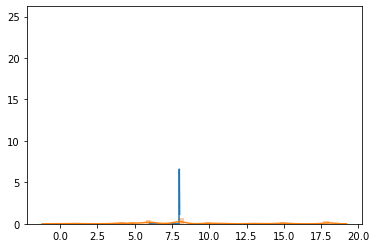

In [67]:
sns.distplot(list(map(lambda x: np.argmax(x), m.predict(tr_X.values)[1])))
sns.distplot(target)

In [60]:
def make_AAE():
#     K.clear_session()
    inputs1 = layers.Input(shape=(tr_X.shape[1], ))
    
    x = layers.Dense(32)(inputs1)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    cl = layers.Dense(19)(x)

    x = layers.Dense(32)(cl)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.advanced_activations.LeakyReLU(0.3)(x)

    outputs1 = layers.Dense(tr_X.shape[1])(x)
    outputs2 = layers.Dense(target_wide.shape[1], activation='softmax')(x)

    m = models.Model(inputs1, [outputs1, outputs2])
    cl = models.Model(inputs1, cl)
    return m, cl